# Chapter 4 - Training Models

This notebook contains the code for chapter 4

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Linear regression

Two different ways of training: 

* Direct closed-form application: directly computes the model parameters that best fit the model to the training set
* Iterative approach (Gradient Descent - GD): gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method
    * Batch GD
    * Mini-batch GD
    * Stochastic GD 
    
A linear model makes a **prediciton** by computing a weighted sum of the input features, plus a constant called *bias term* or *intercept*

$\hat{y} = {\theta}_{0} + {\theta}_{1}{x}_{1} + {\theta}_{2}{x}_{2} + ... + {\theta}_{n}{x}_{n}$ 


Where: 
* $\hat{y}$ = predicted value
* $n$ = number of features
* ${x}_{i}$ = ${i}^{th}$ feature 
* ${\theta}_{j}$ = ${j}^{th}$ model parameter (including the bias term ${\theta}_{0}$ and feature weights ${\theta}_{1}$, ${\theta}_{2}$, ..., ${\theta}_{n}$)

**Vectorised** form: 

$\hat{y} = {h}_{\boldsymbol{\theta}}(x) = \boldsymbol{\theta} \cdot \boldsymbol{x}$ 

Where: 
* ${\theta}$ = model’s *parameter vector*, containing the bias term ${\theta}_{0}$ and the feature
weights ${\theta}_{1}$ to ${\theta}_{n}$
* $x$ = instance’s *feature vector*, containing ${x}_{0}$ to ${x}_{n}$, with ${x}_{0}$ always equal to 1
* $\boldsymbol{\theta} \cdot \boldsymbol{x}$ = is the dot product of the vectors $\boldsymbol{\theta}$ and $x$, which is of course equal to ${\theta}_{0}{x}_{0} + {\theta}_{1}{x}_{1} + {\theta}_{2}{x}_{2} + ... + {\theta}_{n}{x}_{n}$ 
* $h{\theta}$ = hypothesis function, using the model parameters $\boldsymbol{\theta}$

Vectors are represented as *column vectors*: 2D array with single column, then the matrix multiplication can be seen as:  

$\hat{y} = \boldsymbol{\theta}^{T}\boldsymbol{x}$ 


*Process*
* **Training**: setting model's parameters so that it bests fit the training set
* **Performance evaluation**: Root Mean Squared Error (RMSE)
* For Linear regression model: find the value of $\boldsymbol{theta}$ that minimises RMSE
* Easier to minimise MSE (as results the same)

$MSE(\boldsymbol{X}, {h}_{\boldsymbol{\theta}}) = \frac{1}{m} \sum_{i=1}^m(\boldsymbol{\theta}^{T}\boldsymbol{x}^{(i)} - y^{(i)})^2$

### Normal equation

Closed-form method: mathematical equation that finds the value of $\boldsymbol{\theta}$ that minimises the cost funcion MSE

**Normal equation**

$\hat{\boldsymbol\theta} = (\boldsymbol{X}^{T}\boldsymbol{X})^{-1} \boldsymbol{X}^{T} \boldsymbol{y}$ 

Where: 
* $\hat{\boldsymbol\theta}$ = value of ${\boldsymbol\theta}$ that minimises the cost function
* $\boldsymbol{y}$ = vector of target values containing ${y}^{(1)}$ to ${y}^{(m)}$

{}

In [31]:
# Generate linear looking data to test the equation using y = 4 + 3x

import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


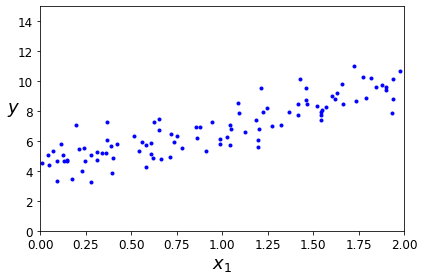

In [4]:
# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

Compute $\hat{\boldsymbol{\theta}}$ using: 
* `inv()` to calculate the inverse of a matrix
* `dot()` for matrix multiplication

In [8]:
# Add X0=1 for all instances
X_b = np.c_[np.ones((100, 1)), X] 

# Calculate theta
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

The expected values are ${\theta}_{0}$ = 4 and ${\theta}_{1}$ = 3

Use $\hat{\boldsymbol{\theta}}$ to make predictions.

In [9]:
# Create new array 
X_new = np.array([[0], [2]])
# Add x0 = 1 to each instance
X_new_b = np.c_[np.ones((2, 1)), X_new] 

# Predict
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

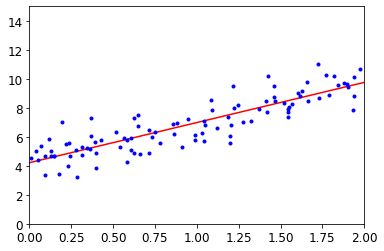

In [10]:
# Plot predictions 

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

**Scikit Learn** can be used to perform Linear Regression

In [11]:
# Import and instantiate model
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

# Fit
lin_reg.fit(X, y)

# Print bias term and features weights 
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

The function is based on `scipy.linalg.lstsq()` which computes the *pseudoinverse* of $\boldsymbol{X}$ based on *Singular Value Decomposition (SVD)*

## Gradient Descent

Tweak parameters iteratively in order to minimise the cost function: 

* Assign a random value to $\boldsymbol{\theta}$
* Measure the local gradient of the error function
* At each step, go in the direction of the descending gradient
* The size of the steps is determined by the *learning rate*. 
* Finally converge to a minimum 

Ensure that all features have a similar scale (e.g., using Scikit-Learn’s `StandardScaler` class), or else it will take much longer to converge. 

### Batch Gradient Descent

Uses the whole batch of training data at every step. 

* Find a good **learning rate**: use grid search, but limit the number of iterations to eliminate models that don't converge
* Set the **number of iterations**: set a very large number of iterations and interrupt the algorithm when the gradient vector becomes smaller than the *tolerance* $\epsilon$


### Stochastic Gradient Descent

Picks a *random* instance in the training set at every step and computes the gradients based only on that single instance: 
* Good to escape from the local optima
* Never settle to the minimum

Gradually **reduce the learning rate** using the *learning schedule* function to determine the learning rate at each step. 

Perform using the `SGDRegressor` class. 



In [13]:
# Import and instantiate
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)

# Fit (ravel to flatten the array)
sgd_reg.fit(X, y.ravel())

# Check parameters
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### Mini-batch Gradient Descent

Computes the gradients on small random sets of instances called mini-batches

**Comparison of algorithms for linear regression**

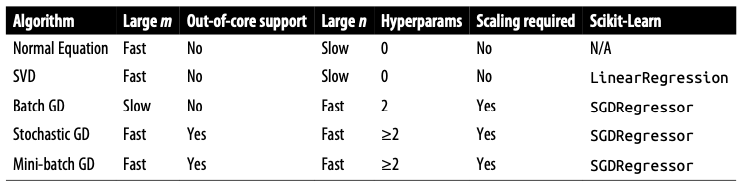

## Polynomial regression

Use linear regression to fit non linear data: add powers of each feature as new features, then train a linear model on this extended set of features. 

In [14]:
import numpy as np
import numpy.random as rnd

np.random.seed(42)

In [15]:
# Generate non linear data
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

Saving figure quadratic_data_plot


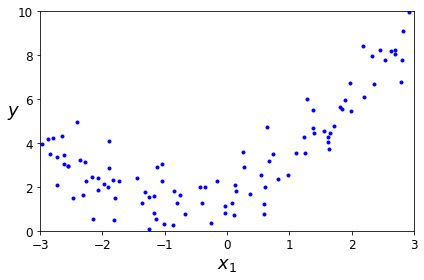

In [16]:
# Plot the data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [17]:
# Import and instantiate class
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)

# Transform data
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([-0.75275929]), array([-0.75275929,  0.56664654]))

In [19]:
# Fit linear regression and get parameters
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

When there are multiple features, Polynomial Regression is capable of finding relationships between features: adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations ab, a2b, and ab2.

PolynomialFeatures(degree=d) transforms an array containing n features into an array containing $(n + d)! / d!n!$ features, where $n!$ is the factorial of $n$, equal to $1 × 2 × 3 × ⋯ × n$. 

## Learning Curves

How to detect **underfitting** or **overfitting**: 
* Cross validation: estimate the model generalisation performance
* Learning curves: plot the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration)

In [28]:
# Define function to plot curves

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Saving figure underfitting_learning_curves_plot


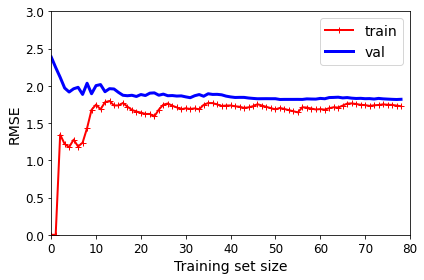

In [29]:
# Plot curves from linear model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3]) 
save_fig("underfitting_learning_curves_plot")
plt.show()

*Underfitting model*

Both curves reaches a plateau and they are very close to each other. 

On TRAIN data 
* Fit well on a few data (close to zero)
* Increases with the addition of new data
* Reaches plateau: adding more data doesn't improve the performance

On VALIDATION data: 
* Big error on few data, because it cannot generalise
* Adding data it learns, so the error goes down
* Plateau, close to the other curve

To improve: increase model complexity

Saving figure learning_curves_plot


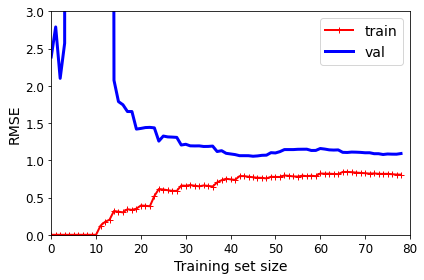

In [30]:
# Plot curves form polynomial model

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")  
plt.show()      

*Overfitting model*

* Error on training data is lower than the one with Linear regression
* Gap between the curves: performs better on the train data compared to the validation data. On a larger train set they will get close

To improve: feed more training data till the validation error reaches the training error


#### The bias/variance trade-off

A model’s generalization error can be expressed as the sum of three errors
* Bias: wrong assumption
    * i.e. assumption of linearity instead of quadratic
    * Underfit training data
* Variance: excessive sensibility to variations in training data
    * i.e. too many degrees of freedom (high polynomial)
    * Overfit
* Irreducible error: noisiness of the data 
    * Clean up the data to remove
    
Increasing a model’s complexity will typically increase its variance and reduce its bias. 
Reducing a model’s complexity increases its bias and reduces its variance.


## Regularised linear models

To reduce overfitting: regularize the linear model (constrain): with few degrees of freedom it's hard to overfit the data. 

* Polynomial model: reduce the number of polynomial degrees
* Linear model: constrain the weights of the model 

### Ridge Regression

*Ridge regression* (or *Tikhonov regularisation*): regularised form of Linear Regression

Add *regularisation term* to cost function: 

${\alpha}\sum_{i=1}^n{\theta}_{i} ^2$

Force learning algorithm
* Fit the data
* Keep the model's weights as small as possible 

Used only during **training**. Once the model is trained, use the unregularised performance measure to evaluate the model performance. It is common for the cost function used during training to be different from the performance measure used for testing. 

**Ridge regression cost function**

$ J(\boldsymbol{\theta}) =  MSE(\boldsymbol{\theta}) + {\alpha}\frac{1}{2}\sum_{i=1}^n{\theta}_{i} ^2$

The bias term ${\theta}_0$ is not regularised. 

**Vector form**

Define $\boldsymbol{w}$ as the vector of feature weights ${\theta}_1$ to ${\theta}_n$, then the regularisation term is equal to: 

$\frac{1}{2}(||\boldsymbol{w}||_2)^2$

Where $||\boldsymbol{w}||_2$ represents the ${l}_2$ norm of the weight vector.

i.e. for Gradient Descent: add ${\alpha}\boldsymbol{w}$ to MSE gradient vector

**Data scaling**

Important to scale the data (`StandardScaler`) as sensitive of the scale of the input features, as most of the regularised models. 

**Hyperparameter ${\alpha}$**

Controls how much you want to regularise of the model. 

${\alpha} = 0$

Same as linear regression 

${\alpha}$ very large

* Weights very close to zero
* Result is flat line going through the mean

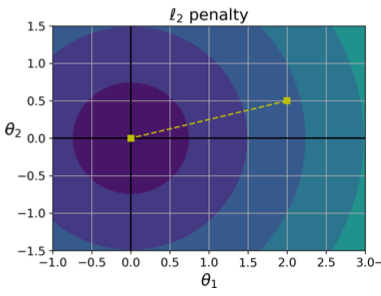

* Axes: two model parameters ${\theta}_1$ and ${\theta}_2$
* Background contours: $l_2$ loss, decreases with the distance to the origin (min)
* Yellow line: decrement of parameters using Gradient Descent. Straight path towards the origin (min)

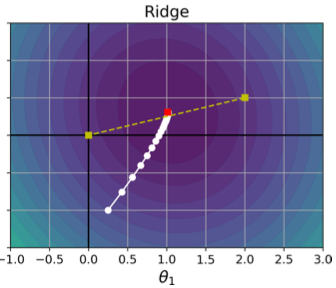

* Gradients get smaller as the parameters approach the global optimum. And Gradient Descent naturally slows down, which helps convergence (as there is no bouncing around)
* Optimal parameters (represented by the red square) get closer and closer to the origin when you increase $\alpha$, but they never get eliminated entirely.

In [34]:
# Get data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

Saving figure ridge_regression_plot


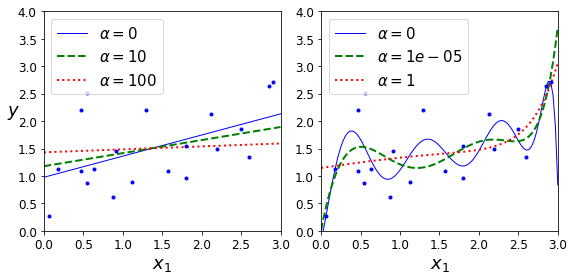

In [35]:
# Plot linear and polynomial with different values of alpha
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler


def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
# Linear predictions
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
# Polynomial predictions
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

Increasing ${\alpha}$ leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias. 

Ridge Regression computation
* Closed form
* Gradient descent

**Closed form**

$\hat{\boldsymbol\theta} = (\boldsymbol{X}^{T}\boldsymbol{X}+{\alpha}\boldsymbol{A})^{-1} \boldsymbol{X}^{T} \boldsymbol{y}$ 

Where:

$\boldsymbol{A}$: $(n+1)\times(n-1)$ identity matrix except with a 0 in the top left cell (bias term)

Scikit Learn can be used to compute the closed form, using `Cholesky` matrix factorisation technique.

`Solver` to use in the computational routines:
* `cholesky` uses the standard `scipy.linalg.solve` function to obtain a closed-form solution


In [36]:
# Instantiate, fit and predict
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

**Stochastic Gradient Descent**

Use the `Ridge` class with the `sag` solver

* `sag` uses a Stochastic Average Gradient descent. Use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Fast convergence is only guaranteed on features with approximately the same scale. Preprocess the data with a scaler from `sklearn.preprocessing`

In [37]:
# Instantiate, fit and predict
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

Use `SGDRegressor` with `l2` penalty
* Penalty parameter set the type of regularisation term to use
* `l2`: regularisation term equals to half the square of the $l_2$ norm of the vector
* Ridge regression

In [39]:
# Instantiate, fit and predict
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### Lasso Regression

*Least Absolute Shrinkage and Selection Operator Regression*: regularised version of Linear Regression. 

Adds a regularisation term to the cost function, using $l_1$ norm:

$ J(\boldsymbol{\theta}) =  MSE(\boldsymbol{\theta}) + {\alpha}\sum_{i=1}^n\mid{\theta}_{i}\mid$

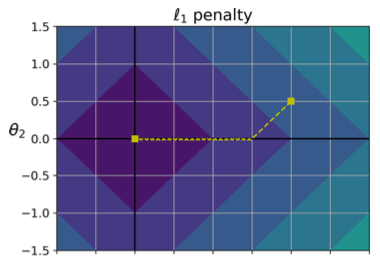
* Axes: two model parameters ${\theta}_1$ and ${\theta}_2$
* Background contours: $l_1$ loss $(\mid{\theta}_1\mid + \mid{\theta}_2\mid)$, linear drop as you get closer to any axis
* Yellow line: decrement of parameters using Gradient Descent. ${\theta}_2$ will reach 0 first since it was closer to zero to begin with 

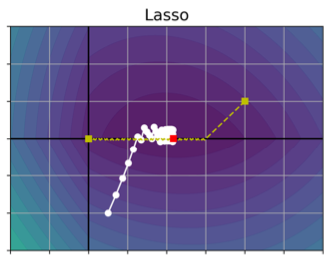

The path quickly reaches ${\theta}_2 = 0$, then rolls down the gutter and ends up bouncing around the global optimum (represented by the red square)

* Increase $\alpha$: global optimum would move left along the dashed yellow line
* Decrease $\alpha$: global optimum would move right 

To avoid Gradient Descent from bouncing around the optimum at the end when using Lasso, gradually reduce the learning rate during training (it will still bounce around the optimum, but the steps will get smaller and smaller, so it will converge).

Plot Lasso regression models with small $\alpha$ values.


/Users/arzuffi/Documents/ML/hands-on_ML/ho_env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827432, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


Saving figure lasso_regression_plot


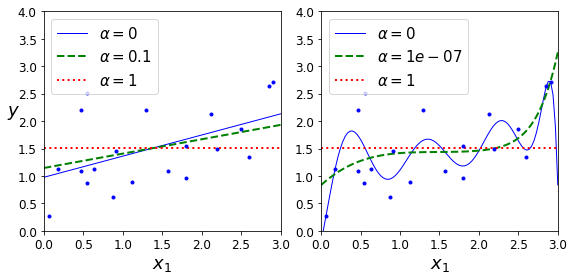

In [40]:
# Plot Lasso
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

Lasso Regression tends to eliminate the weights of the least important features (i.e., set them to zero)
* All the weights for the high-degree polynomial features are equal to zero
* Automatically performs feature selection and outputs a *sparse model* (i.e., with few nonzero feature weights)

At $\theta_i = 0$ (for $i$ = 1, 2, ..., $n$)
* Lasso cost function is not differentiable
* Use *subgradient vector* $\boldsymbol{g}$

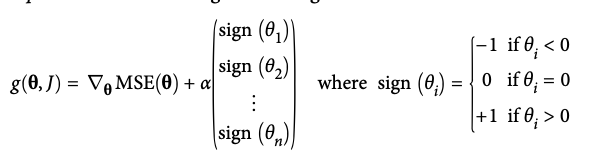

Example of use:
* `SGDRegressor(penalty=l1)`
* `Lasso` class from Scikit Learn

In [42]:
from sklearn.linear_model import Lasso

# Instantiate model and define alpha
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic Net

Mix of Ridge and Lasso regularisation terms

Elastic Net cost function: 

$ J(\boldsymbol{\theta}) =  MSE(\boldsymbol{\theta}) + r{\alpha}\frac{1}{2}\sum_{i=1}^n{\mid}{\theta}_{i}\mid + \frac{1-r}{2}{\alpha}\sum_{i=1}^n{\theta}_{i}^2$

Control the *mix ratio* $r$ (`l1_ratio`)
* $r=0$: equivalent to Ridge regression
* $r=1$: equivalent to Lasso regression

Example of use:

In [43]:
from sklearn.linear_model import ElasticNet

#Instantiate and set alpha and mix ratio
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([1.54333232])

When to use the different kind of regression
* **Plain** linear regression: avoid
* **Ridge**: good default
* **Lasso**: use when only a few features are useful. To avoid because of erratic behaviour: 
    * Number of feature is larger than the number of training instances
    * Several features are strongly correlated
* **Elastic Net**: use when only a few feaures are useful. Preferred over Lasso, when erratic behaviour

### Early Stopping

Stop training an iterative learning algorithm as soon as the validation error reaches a minimum (other way for regularisation). 

Example: high degree Polynomial Regression model trained with Batch Gradient Descent

In [44]:
# Generate data
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [45]:
# Early stopping 
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Saving figure early_stopping_plot


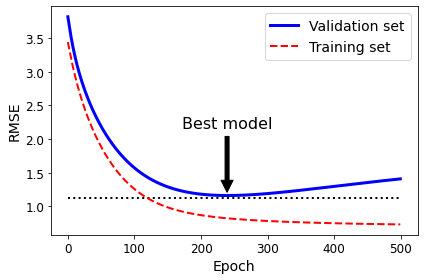

In [46]:
# Plot the graph
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

* With training, prediction errors (RMSE) on the training and validation sets go down
* After a while, the validation error stops decreasing, and starts increasing (model overfits training data)
* Early stopping: stop when error reaches the minimum

Curves less smooth with Stochastic and Mini-Batch Gradient (more difficult to see if minimum has been reached):
* Stop after the validation error has been over the minimum for some time (model won't improve)
* Roll back the model's parameters to the minimum

Use `warm_state=True` in the Regressor, so when the `fit` method is called, the training continues where it left off, instead of starting from scratch. 

## Logistic Regression

Regression algorithm can be used for classification. 

*Logistic (or Logit) Regression* used to estimate the probability that an instance belongs to a class (**Binary classifier**):
* Estimated probability $\hat{p}$ > 50%: model predicts that instance belongs to *positive class* (label $1$)
* Estimated probability $\hat{p}$ < 50%: model predicts that instance belongs to *negative class* (label $0$)

### Estimating Probabilities

* Compute a weighted sum of the input features plus a bias term
* Output *logistic* $\sigma$ of the result

$\hat{p} = h_{\theta}(\boldsymbol{x}) = \sigma(\boldsymbol{x}^T\boldsymbol{\theta})$ 

**Logistic** $\sigma(\cdot)$:
* Sigmoid function
* Outputs a number between 0 an 1

$\sigma(t) = \frac{1}{1 + exp(-t)}$

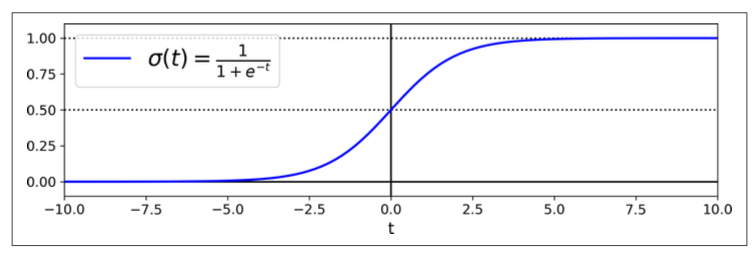


**Make predictions**

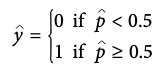

Predicts 1
* $\sigma(t) \geq 0.5$
* $t \geq 0$
* $\boldsymbol{x}^T\boldsymbol{\theta} \geq 0$

Predicts 0
* $\sigma(t) < 0.5$
* $t < 0$
* $\boldsymbol{x}^T\boldsymbol{\theta} < 0$

$t$ called
* *Logit*: because logit function $logit(p) = log(p/(1-p))$ is the inverse of the logistic function
* *Log-odds*: because it is the log of the ratio between the estimated probability for the positive class and the estimated probability for the negative class

### Training and Cost Function

Objective of training of Logistic Regression: set the parameter vector $\boldsymbol{\theta}$ so that the model estimates: 
* High probabilities for positive instances (y=1)
* Low probabilities for negative instances (y=0)

**Cost function on a single instance**

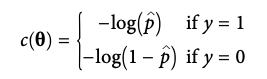

* $-log(t)$ is large when $t$~0. Large cost when
    * Estimate a probability close to 0 for positive instance. Use $-log(\hat{p})$
    * Estimate a probability close to 1 for negative instance. Use $-log(1-\hat{p})$
* $-log(t)$ ~ 0 when $t$~1. Small cost when
    * Estimate a probability close to 1 for positive instance. Use $-log(\hat{p})$
    * Estimate a probability close to 0 for negative instance. Use $-log(1-\hat{p})$
    
**Cost function over the whole training set**

*Log loss*: average cost all over the training instances

$J(\boldsymbol{\theta}) = -\frac{1}{m}\sum_{i=1}^m[y^{(i)}log(\hat{p}^{(i)})+(1-y^{(i)})log(1-\hat{p}^{(i)})]$

* No closed-form equation to compute the value of $\boldsymbol{\theta}$ that minimises the cost function
* Convex function: guaranted that optimisation algorithms will find the global minimum (if learning rate is not too large, and you wait long enough)

**Partial derivatives of the cost function**

$\frac{\partial}{\partial \theta}J(\boldsymbol{\theta})=-\frac{1}{m}\sum_{i=1}^m(\sigma(\boldsymbol{\theta}^T\boldsymbol{x}^{(i)})-y^{(i)})x^{(i)}_j$


* Compute prediction error 
* Multiplie it by the $j^{th}$ feature value
* Compute the average over all training instances

Train Logistic Regression model: 
* Batch Gradient Descent: use gradient vector containig all the partial derivatives
* Stochastic GD: use one instance at a time
* Mini-batch GD: use a batch at a time

### Decision Boundaries

Example: Use the iris dataset 

In [47]:
# Import dataset from Scikit Learn

from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [48]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Build a classifier to detect the *Iris virginica* type based only on the petal width feature. 

In [51]:
# Create X and y
X = iris["data"][:, 3:]  # petal width
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris virginica, else 0

In [54]:
# Train Logistic Regression model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

Look at the model’s estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm

In [55]:
# Estimate probabilities

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

/Users/arzuffi/Documents/ML/hands-on_ML/ho_env/lib/python3.9/site-packages/matplotlib/patches.py:1338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


Saving figure logistic_regression_plot


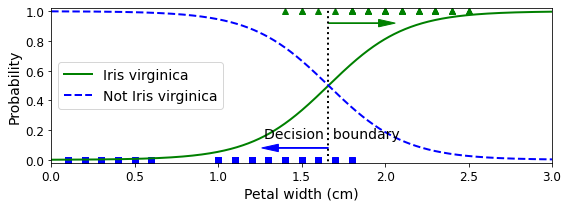

In [56]:
# Plot
plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

Overlap between the two categories
* >2 confident that it is *Iris virginica* (high probability for that class) 
* <1 confident that it's not *Iris virginica* (high probability for the Not *Iris virginica* class)
* In between uncertainty 

If using the `predict()` method to predict the class it will return which class is more likely, even if it's not very confident. 

*Decision boundary* where both probability are 50%

In [57]:
# Display decision boundary (calculated above)
decision_boundary

array([1.66066066])

In [58]:
# Make predictions close to the decision boundary (even if not confident)
log_reg.predict([[1.7], [1.5]])

array([1, 0])

New model with two categories (petal width and length)

In [61]:
# Get data
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

In [62]:
# Fit model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

In [63]:
# Create data for predictions
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

In [65]:
# Estimate predictions
y_proba = log_reg.predict_proba(X_new)

Saving figure logistic_regression_contour_plot


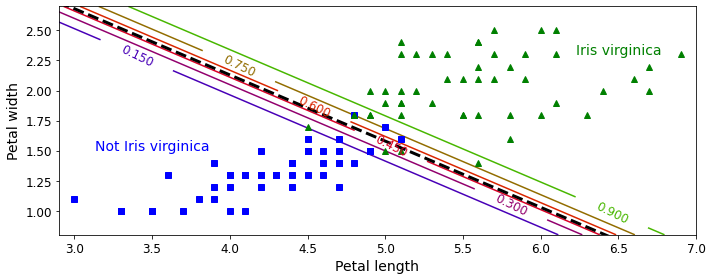

In [66]:
# Plot
plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

Dashed line = decision boundary 
* The model estimates 50% probability
* Linear boundary

Each parallel line represents the point where the model outputs a specific probability. 

**Regularisation**

Logistic regression regularised using $l1$ or $l2$ penalties. 
* Scikit learn adds $l2$ penalty by default
* `C` hyperparameter controlling regularisation (inverse of `alpha`)
* The higher `C` is, the *less* the model is regularised

### Softmax Regression

*Softmax Regression* or *Multinomial Logistic Regression*: generalisation of Logistic Regression to support multiple classes directly, without having to train and combine multiple binary classifiers. 

Given an instance $\boldsymbol{x}$:
1. Compute a score $s_{k}(\boldsymbol{x})$ for each class $k$
2. Estimate the probability of each class by applying the *softmax function* (or *normalised exponential*) to the scores

**Compute score**

Equation similar to the one for Linear Regression Predictions

$s_{k}(\boldsymbol{x}) = \boldsymbol{x}^T\boldsymbol{\theta}^{(k)}$

* Parameter vector $\boldsymbol{\theta}^{(k)}$ for every class
* Parameter matrix $\Theta$ to store all parameter vectors

Compute score for every clas of the instance $\boldsymbol{x}$ called *logits* or *log-odds*

**Estimate probability**

Runnig the scores to the softmax function to estimate the probability $\hat{p}_k$ that the instance belongs to the class 
* Computes the exponential of every score
* Normalise them by dividing them by the sum of all the exponentials

*Softmax function*

$\hat{p}_k = \sigma(\boldsymbol{s}(\boldsymbol{x}))_k = \frac{exp(s_k(\boldsymbol{x}))}{\sum_{j=1}^K exp(s_j(\boldsymbol{x}))}$

Where:
* $K$: number of classes
* $s(\boldsymbol{x})$: vector containing the scores of each class for the instance $\boldsymbol{x}$
* $\sigma(\boldsymbol{s}(\boldsymbol{x}))_k$: estimated probability that the instance $\boldsymbol{x}$ belongs to class $k$ given the scores of each class for that instance

**Predictions**

Softmax Regression classifier predicts the class with the highest estimated probability (highest score). 

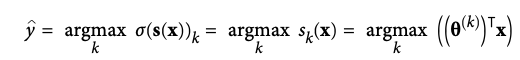

*argmax* operator
* Returns the value of a variable that maximises a function
* In this case, it returns the value of $k$ that maximises the estimated probability $\sigma(\boldsymbol{s}(\boldsymbol{x}))_k$

Softmax Regression classifier predicts a class at a time, so it should be used ony with *mutually exclusive clases*. 

**Training**

Objective: have a model that estimates a high probability for the target class, and low probability for the other classes. 

*Cross entropy* (cost function) 

$J(\boldsymbol{\Theta})= - \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$

Where: 
* $y_{k}^{(i)}$: target probability that the $i^{th}$ instance belongs to class $k$. Either 0 or 1, depending on whether in instance belongs to the class or not
* For K=2 it's equivalent to the Logistic Regression cost function

Minimising the *cross entropy* function leads to the objective, because it penalises the model when it estimates a low probability for a target class. 
Cross entropy function used to measure how well a set of estimated class probabilities matches the target classes. 

**Gradient vector** 

Gradient vector of the cost function with regards to $\boldsymbol{\theta}^{(k)}$

$\nabla_{\boldsymbol{\theta}^{(k)}}J(\boldsymbol{\Theta}) = \frac{1}{m}\sum_{i=1}^{m}(\hat{p}_k^{(i)}-y_k^{(i)})\boldsymbol{x}^{(i)}$

* Compute the gradient vector for every class
* Use Gradient Descent (or other optimisation algorithm) to find the parameter matrix $\boldsymbol\Theta$ that minimises the cost function

Example: Use softmax regression to classify the iris flowers in three classes
* One-versus-the-rest: Scikit Learn default
* Softmax Regression: hyperparameter `multi_class = multinomial`
* Solver that supports Softmax Regression: `lbfgs`
* $l2$ regularisation applied by default and controlled using the hyperparameter `C`

In [68]:
# Get data
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

In [69]:
# Fit the model
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [70]:
# Make data for predictions 
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

In [71]:
# Make predictions 
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

Saving figure softmax_regression_contour_plot


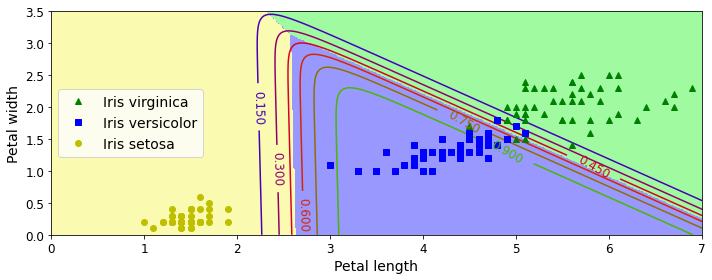

In [72]:
# Plot
zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [73]:
# Predicts 
softmax_reg.predict([[5, 2]])

array([2])

In [74]:
# Prediction estimates
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

* Linear decision boundaries
* The model can predict a class that has an estimated probability < 50% (i.3. 33% where the decision boundaries met)

## Exercises

1. Which Linear Regression training algorithm can you use if you have a training set with millions of features?

Stochastist Gradient Descent or Mini-Batch Gradient Descent

2. Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?


* Gradient Descent will take a long time to converge. Scale the data before training. 
* Normal Equation and SVD do not need scaling. 
* Regularised models can converge to a suboptimal solution if the features are not scaled

3. Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?

Cost function is convex, cannot get stuck in a local minimum. 

4. Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?

Approach global minimum and producing similar models, if
* Convex optimisation problem
* Learning rate not too high

However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.

5. Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

The learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.

6. Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training itera‐ tion. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.

7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?

Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.


8. Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an $l2$ penalty (Ridge) or an $l1$ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.

9. Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularisation hyperparameter $\alpha$ or reduce it?

If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter $\alpha$.


10. Why would you want to use:
    1. Ridge Regression instead of plain Linear Regression (i.e., without any regularisation)?
    A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
    2. Lasso instead of Ridge Regression?
    Lasso Regression uses an $l1$ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
    3. Elastic Net instead of Lasso?
    Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?
If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.
12. Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).